In [3]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [4]:
report_file = 'battery-report.html'

In [5]:
tables = pd.read_html(report_file)

### Basic Info

In [10]:
basic_info = tables[0]
pprint(basic_info)

                     0                                        1
0        COMPUTER NAME                                   ALPHA1
1  SYSTEM PRODUCT NAME                     Acer Aspire A515-57G
2                 BIOS                         V1.08 04/25/2022
3             OS BUILD  22621.1.amd64fre.ni_release.220506-1250
4        PLATFORM ROLE                                   Mobile
5    CONNECTED STANDBY                                Supported
6          REPORT TIME                      2024-11-10 19:44:43


### Battery Info

In [11]:
battery_info = tables[1]
pprint(battery_info)

             Unnamed: 0  BATTERY  1
0                  NAME     AP20CBL
1          MANUFACTURER       COSMX
2         SERIAL NUMBER        1979
3             CHEMISTRY        Li-I
4       DESIGN CAPACITY  53,015 mWh
5                   NaN         NaN
6  FULL CHARGE CAPACITY  42,146 mWh
7           CYCLE COUNT           -


### Recent usage table

In [6]:
recent = tables[2].copy()
recent.head(5)

,START TIME,STATE,SOURCE,CAPACITY REMAINING,CAPACITY REMAINING.1
0,2024-11-07 19:47:47,Active,Battery,100 %,"42,146 mWh"
1,21:48:13,Connected standby,Battery,32 %,"13,340 mWh"
2,21:48:18,Suspended,NaN,32 %,"13,283 mWh"
3,2024-11-08 07:40:25,Connected standby,Battery,30 %,"12,763 mWh"
4,07:41:00,Active,Battery,30 %,"12,474 mWh"


In [7]:
def get_date(x):
    if len(x) == 19:
        return x.split(' ')[0]
    return np.nan
def get_time(x):
    if len(x) == 19:
        return x.split(' ')[1]
    return x

def handle_time(df,col,drop=True):
    df['Date'] = df[col].apply(get_date)
    df['Date'] = df['Date'].ffill()
    df['Time'] = df[col].apply(get_time)
    df[col] = pd.to_datetime(df['Date']+' '+df['Time'], format='%Y-%m-%d %H:%M:%S')
    if drop:
        df.drop(['Date','Time'],axis=1,inplace=True)

def remove_percent(df,col):
    df[col] = df[col].str.replace(' %','').astype(float)

In [10]:
def get_usage_plot(df):
    plt.figure(figsize=(10,4), facecolor='white')
    plt.style.use('seaborn-v0_8-whitegrid')

    # Plot the entire line in blue
    plt.plot(df['START TIME'], df['CAPACITY REMAINING'], 
            color='#1E90FF',  # Dodger blue
            linewidth=2, 
            alpha=0.7)

    # Set plot title and axis labels
    start_day = df['START TIME'].min().date()
    end_day = df['START TIME'].max().date()
    plt.title(f'Battery Consumption between {start_day} - {end_day}', 
            fontsize=14, fontweight='bold', color='#333333')
    plt.xlabel('Start Time', fontsize=10, color='#666666')
    plt.ylabel('Capacity Remaining (%)', fontsize=10, color='#666666')

    # Format x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n %d/%m'))
    plt.xticks(rotation=0, ha='right', fontsize=8, color='#666666')
    plt.yticks(fontsize=8, color='#666666')

    # Set x-axis limits and ticks
    plt.xlim(df['START TIME'].min(), df['START TIME'].max())
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))

    # Add grid
    plt.grid(True, linestyle='--', linewidth=0.5, color='#E0E0E0')

    plt.tight_layout()
    return plt

In [8]:
handle_time(recent,'START TIME',drop=False)
remove_percent(recent,'CAPACITY REMAINING')
recent.head(5)

,START TIME,STATE,SOURCE,CAPACITY REMAINING,CAPACITY REMAINING.1,Date,Time
0,2024-11-07 19:47:47,Active,Battery,100.0,"42,146 mWh",2024-11-07,19:47:47
1,2024-11-07 21:48:13,Connected standby,Battery,32.0,"13,340 mWh",2024-11-07,21:48:13
2,2024-11-07 21:48:18,Suspended,NaN,32.0,"13,283 mWh",2024-11-07,21:48:18
3,2024-11-08 07:40:25,Connected standby,Battery,30.0,"12,763 mWh",2024-11-08,07:40:25
4,2024-11-08 07:41:00,Active,Battery,30.0,"12,474 mWh",2024-11-08,07:41:00


<module 'matplotlib.pyplot' from 'c:\\Users\\Sufya\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\battery-report-analysis-6fU-tPu0-py3.11\\Lib\\site-packages\\matplotlib\\pyplot.py'>

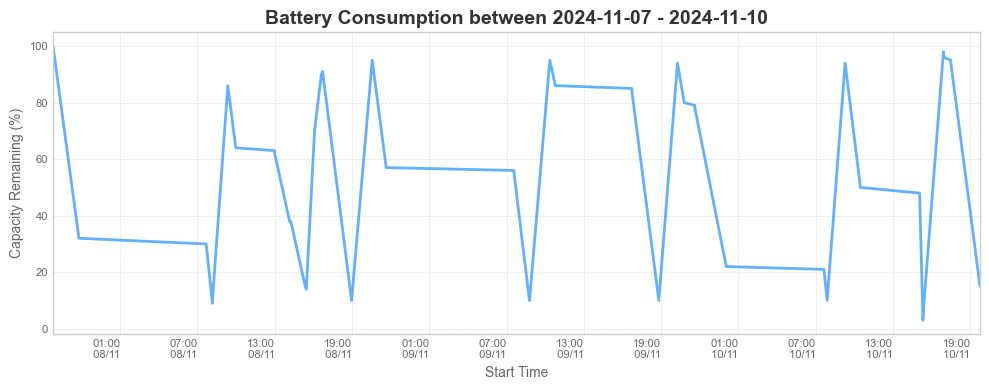

In [11]:
get_usage_plot(recent)